In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
plt.style.use('fivethirtyeight')

In [40]:
headers= {
    'Host': 'stats.nba.com', 
    'Connection': 'keep-alive', 
    'Accept': 'application/json, text/plain, */*', 
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36', 
    'Referer': 'https://stats.nba.com/', 
    'Accept-Encoding': 'gzip, deflate, br', 
    'Accept-Language': 'en-US,en;q=0.9',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
}

In [41]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 45, 10)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 45, 10)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [42]:
def get_tracking_data(team_id):
    interesting_columns = ['DRIVE_PTS',
       'CATCH_SHOOT_PTS', 'PULL_UP_PTS', 'PAINT_TOUCH_PTS',
       'POST_TOUCH_PTS', 'ELBOW_TOUCH_PTS']
    tracking_stats = LeagueDashPtStats(pt_measure_type='Efficiency', season_type_all_star="Playoffs", per_mode_simple='PerGame')

    teams_tracking_df = tracking_stats.get_data_frames()[0]
    playoff_tracking_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == team_id].loc[:, interesting_columns].iloc[0]
    
    tracking_stats = LeagueDashPtStats(pt_measure_type='Efficiency', per_mode_simple='PerGame')

    teams_tracking_df = tracking_stats.get_data_frames()[0]
    regular_tracking_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == team_id].loc[:, interesting_columns].iloc[0]
    
    
    return regular_tracking_df, playoff_tracking_df

In [43]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}
play_types_seasons_playoff = {}


    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='T', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict

def download_play_type_data_playoffs(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons_playoff:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(season_type_all_star='Playoffs', player_or_team_abbreviation='T', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons_playoff[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons_playoff[season]

    
    return play_type_dict





In [44]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["TEAM_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='TEAM_NAME')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='TEAM_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [45]:
cur_year = download_play_type_data(season='2020-21')

Retrieving play types...


In [13]:
cur_po = download_play_type_data_playoffs(season='2020-21')

Retrieving play types...


In [51]:
lakers_color = '#552583'
suns_color = '#E56020'
lakers_second = '#FDB927'
suns_second = '#1D1160'


In [31]:
reg_df = get_interesting_data(cur_year, 'PTS')
po_df = get_interesting_data(cur_po, 'PTS')

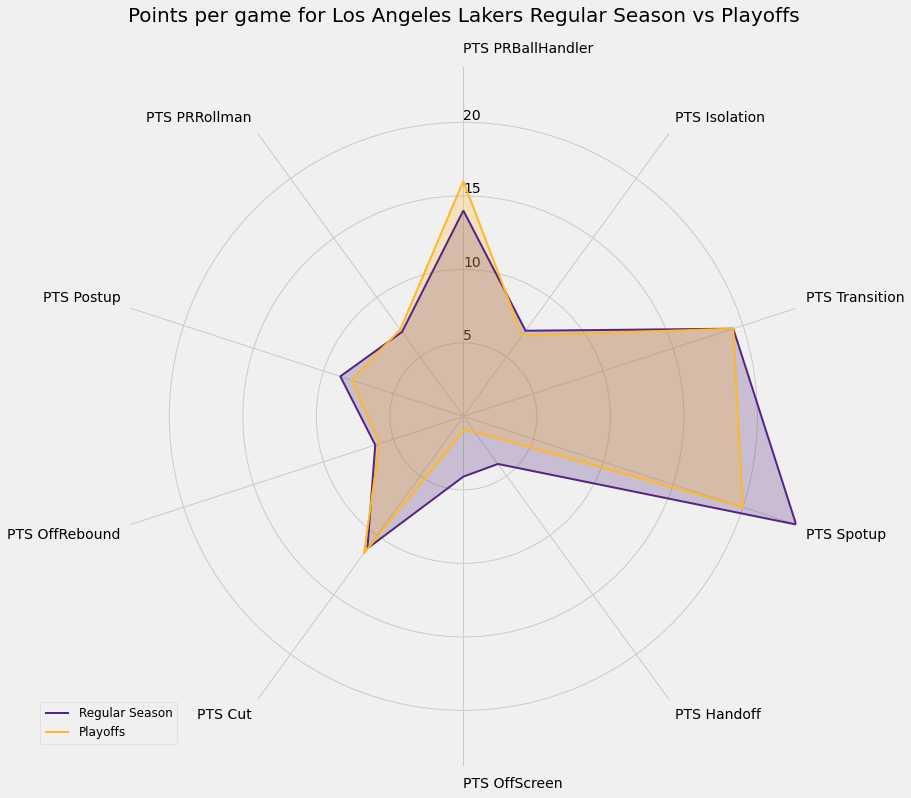

In [32]:
team_name = 'Los Angeles Lakers'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = reg_df.loc[reg_df.TEAM_NAME == team_name]
second_df = po_df.loc[po_df.TEAM_NAME == team_name]

#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Points per game for {team_name} Regular Season vs Playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=["Regular Season", "Playoffs"],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)


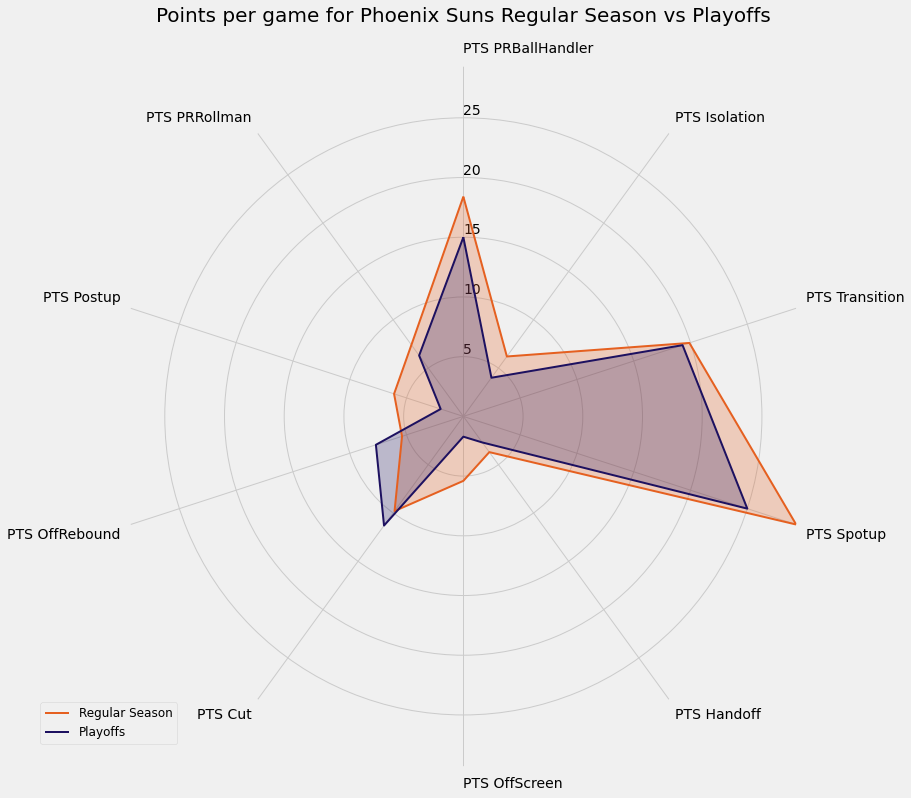

In [33]:
team_name = 'Phoenix Suns'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = reg_df.loc[reg_df.TEAM_NAME == team_name]
second_df = po_df.loc[po_df.TEAM_NAME == team_name]

#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Points per game for {team_name} Regular Season vs Playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=["Regular Season", "Playoffs"],
    colors=[
        suns_color,
        suns_second
    ],
    alphas=[0.25, 0.25]
)


## Poss pct

In [34]:
reg_df = get_interesting_data(cur_year, 'POSS_PCT')
po_df = get_interesting_data(cur_po, 'POSS_PCT')

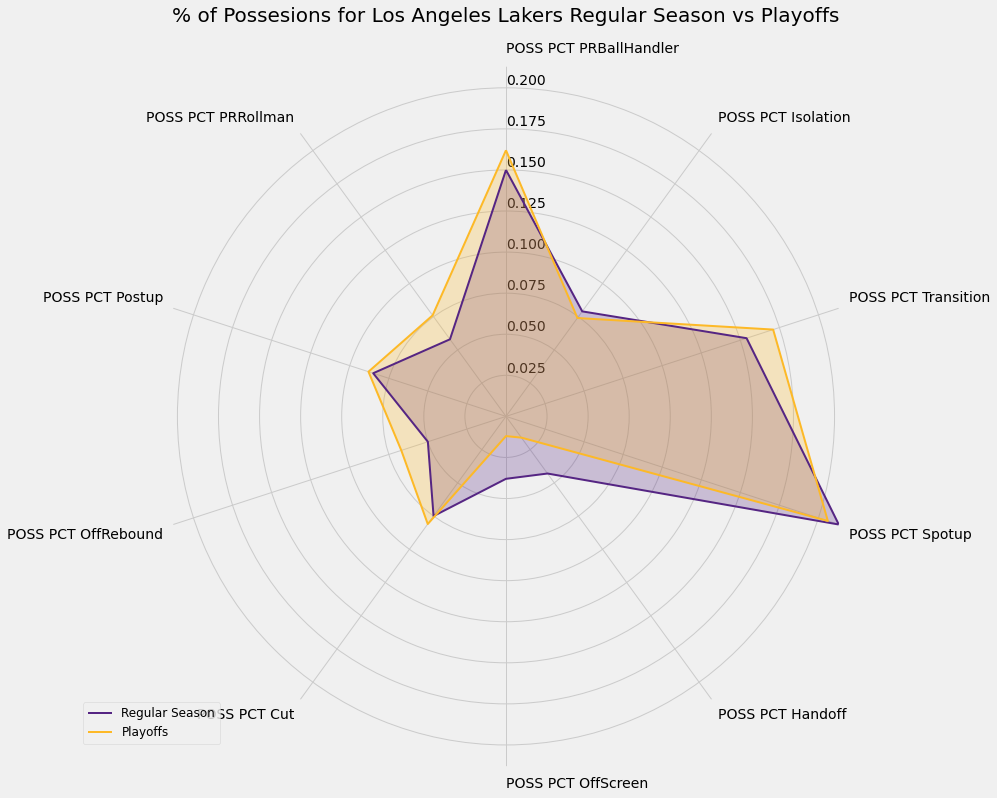

In [35]:
team_name = 'Los Angeles Lakers'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = reg_df.loc[reg_df.TEAM_NAME == team_name]
second_df = po_df.loc[po_df.TEAM_NAME == team_name]

#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"% of Possesions for {team_name} Regular Season vs Playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=["Regular Season", "Playoffs"],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)


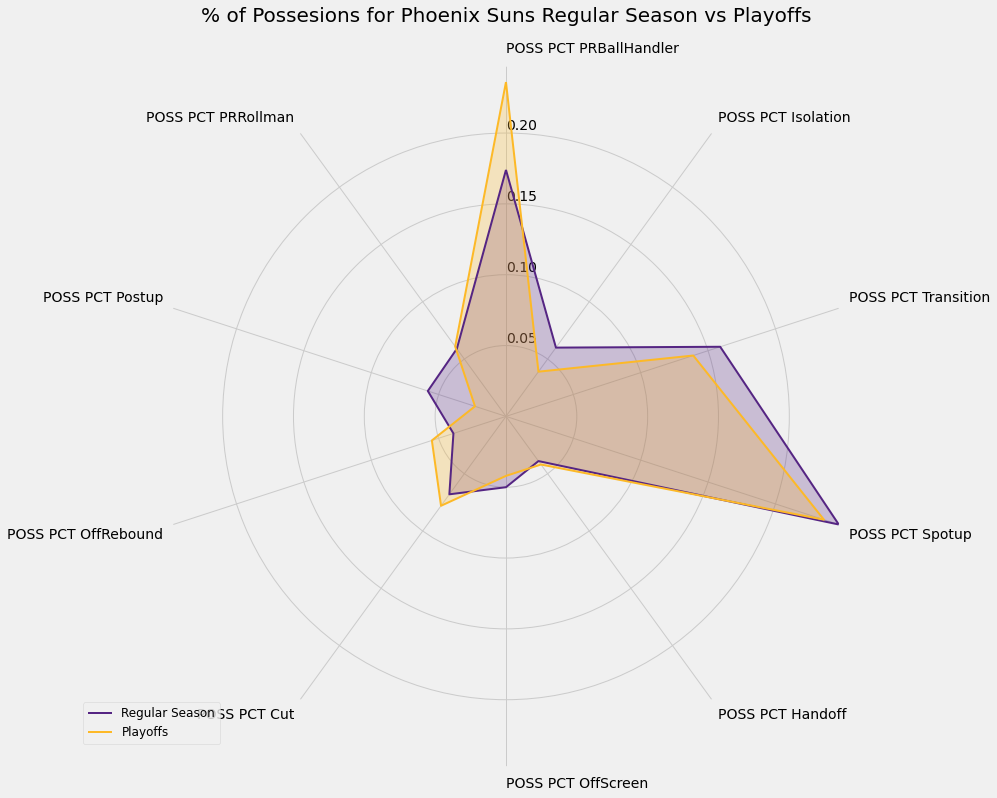

In [36]:
team_name = 'Phoenix Suns'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = reg_df.loc[reg_df.TEAM_NAME == team_name]
second_df = po_df.loc[po_df.TEAM_NAME == team_name]

#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"% of Possesions for {team_name} Regular Season vs Playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=["Regular Season", "Playoffs"],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)


## Play type distribution per player

In [46]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

player_play_types_seasons = {}
player_play_types_seasons_playoffs = {}


    
def download_player_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in player_play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(season_type_all_star='Regular Season', player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        player_play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = player_play_types_seasons[season]

    
    return play_type_dict


def download_player_play_data_playoffs(season='2019-20'):
    
    play_type_dict = {}
    if season not in player_play_types_seasons_playoffs:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(season_type_all_star='Playoffs', player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        player_play_types_seasons_playoffs[season] = play_type_dict
    else:
        play_type_dict = player_play_types_seasons_playoffs[season]

    
    return play_type_dict




In [47]:
def get_interesting_data_player(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    return final_df


def get_merged_data_player(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [48]:
cur_reg_player = download_player_play_type_data(season='2020-21')

cur_po_player = download_player_play_data_playoffs(season='2020-21')

Retrieving play types...
Retrieving play types...


In [65]:
data_type = 'POSS_PCT'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

### Suns players

## Booker

In [73]:
data_type = 'POSS_PCT'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

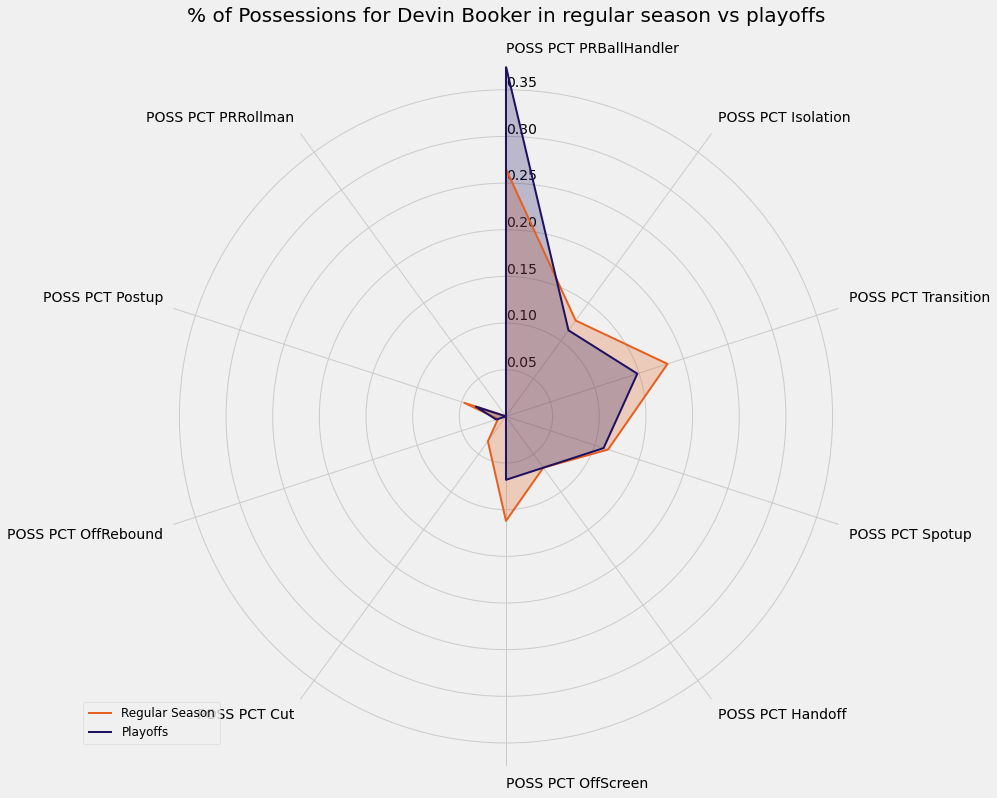

In [74]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Devin Booker'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"% of Possessions for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        suns_color,
        suns_second
    ],
    alphas=[0.25, 0.25]
)

In [79]:
data_type = 'PPP'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

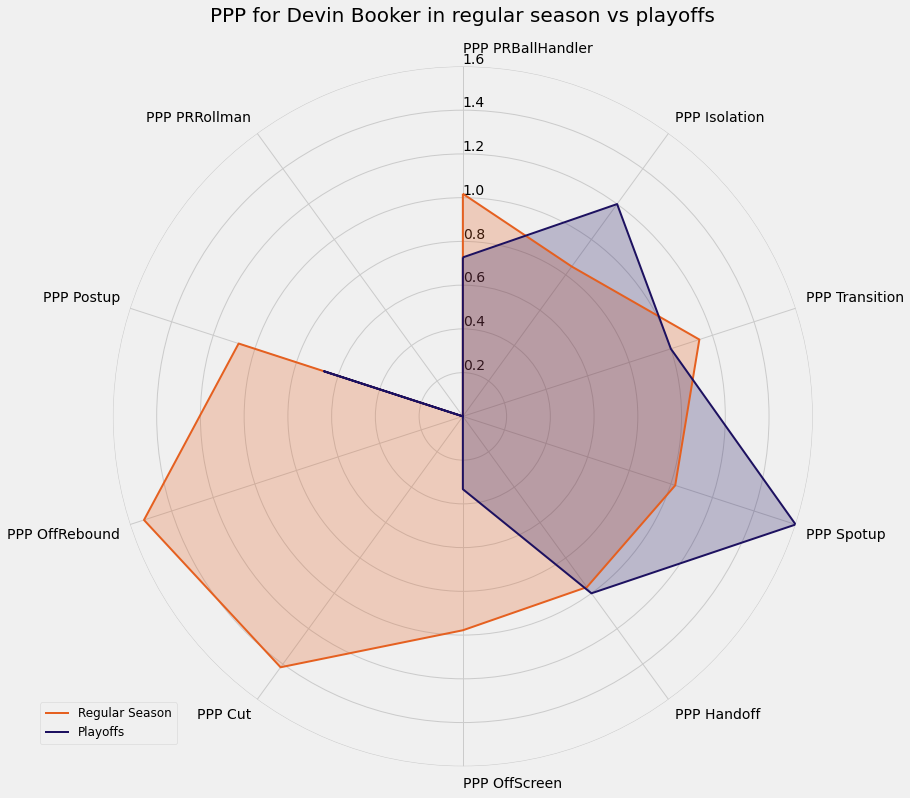

In [80]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Devin Booker'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"PPP for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        suns_color,
        suns_second
    ],
    alphas=[0.25, 0.25]
)

## Ayton

In [52]:
data_type = 'POSS_PCT'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

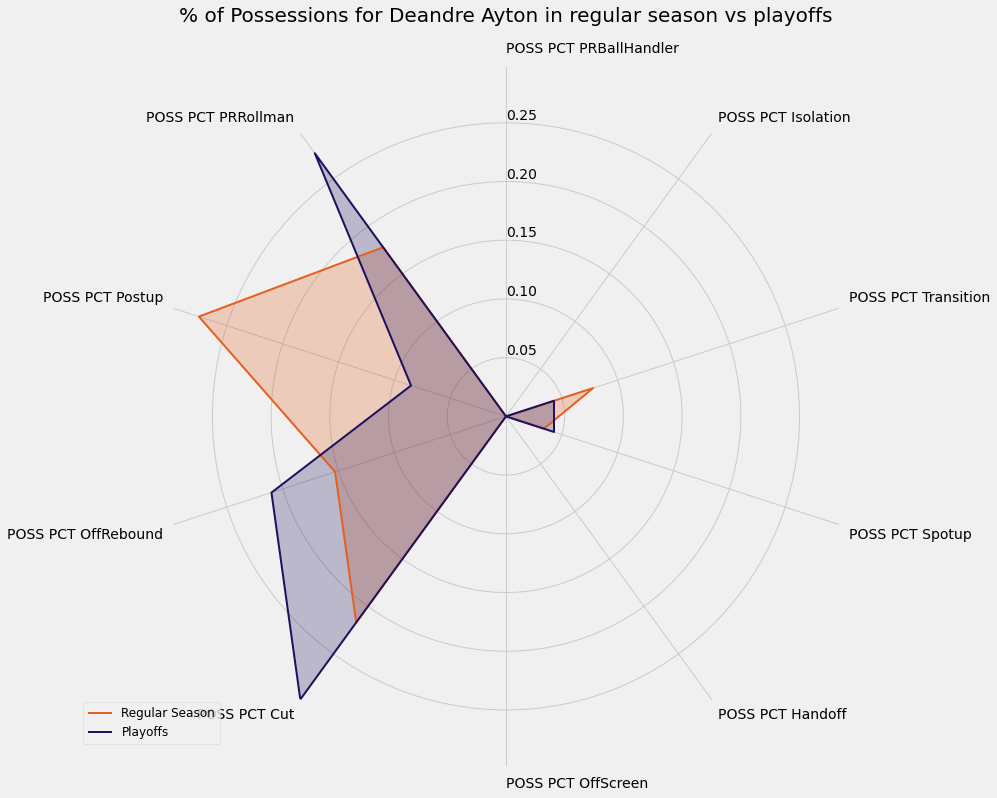

In [53]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Deandre Ayton'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"% of Possessions for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        suns_color,
        suns_second
    ],
    alphas=[0.25, 0.25]
)

In [54]:
data_type = 'PPP'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

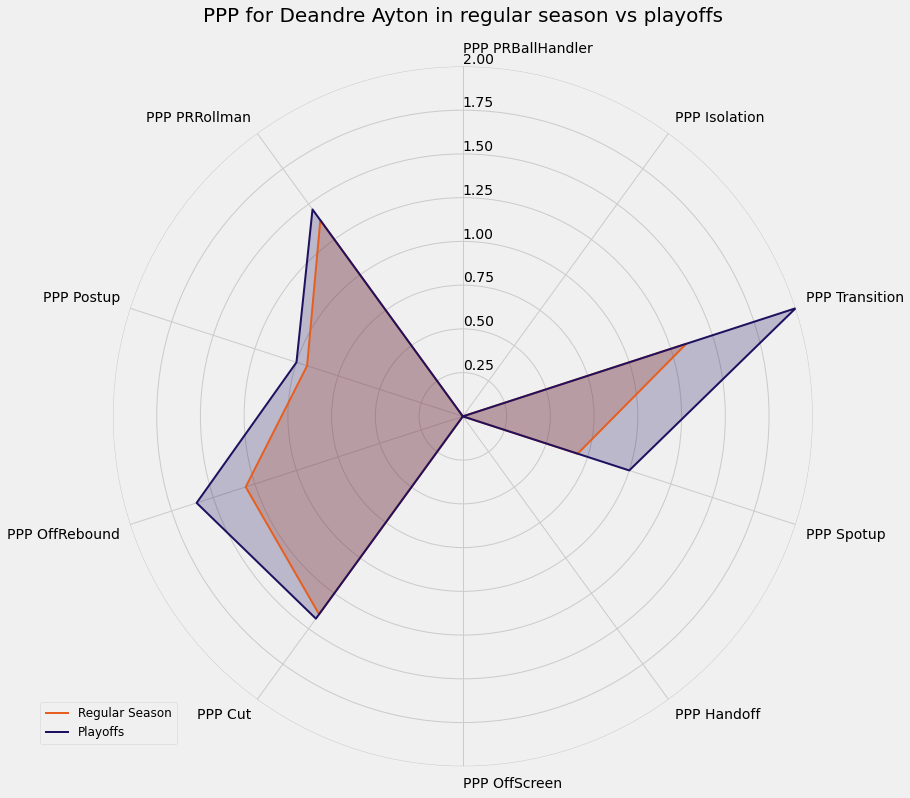

In [55]:
data_type = 'PPP'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Deandre Ayton'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"PPP for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        suns_color,
        suns_second
    ],
    alphas=[0.25, 0.25]
)

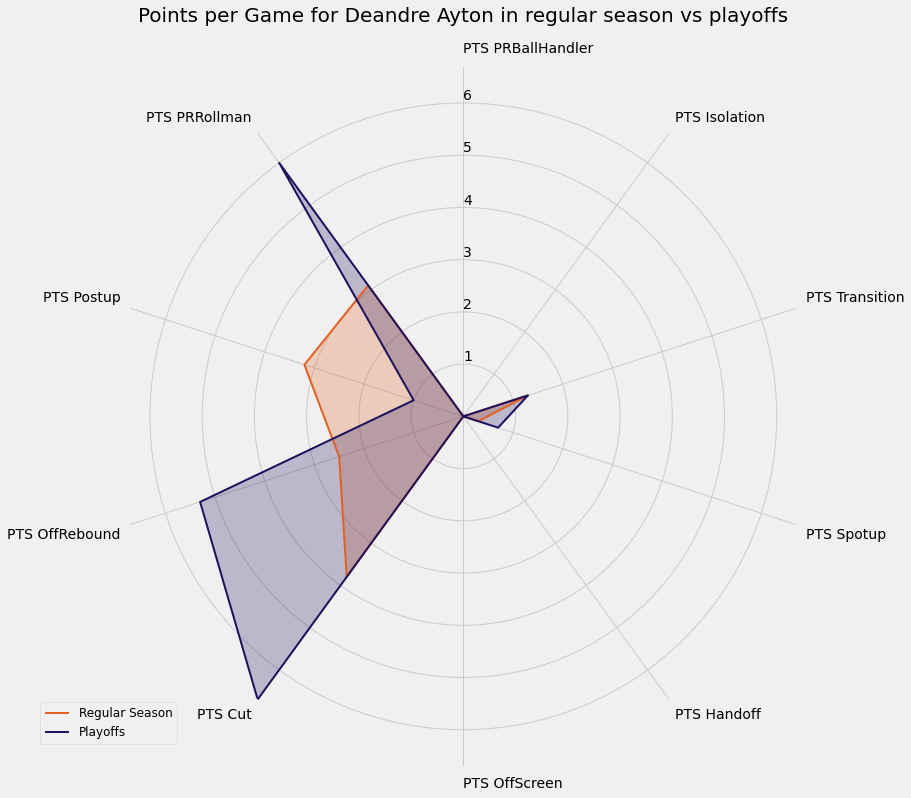

In [61]:
data_type = 'PTS'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Deandre Ayton'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"Points per Game for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        suns_color,
        suns_second
    ],
    alphas=[0.25, 0.25]
)

### Lakers players

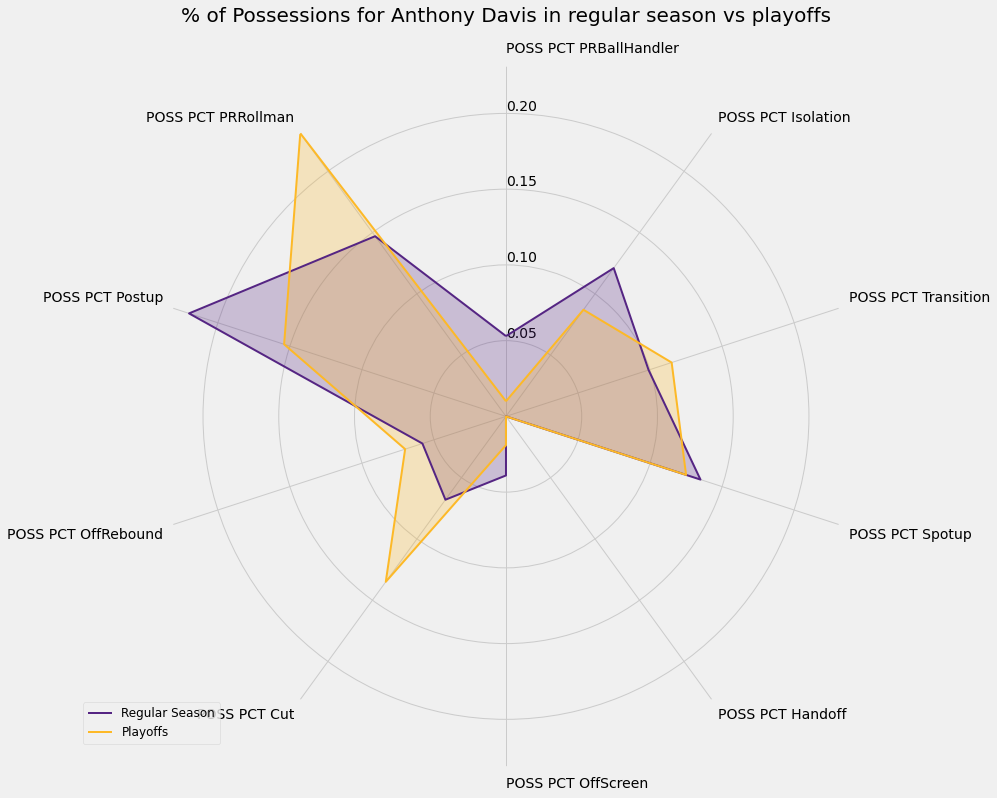

In [56]:
data_type = 'POSS_PCT'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Anthony Davis'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"% of Possessions for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)

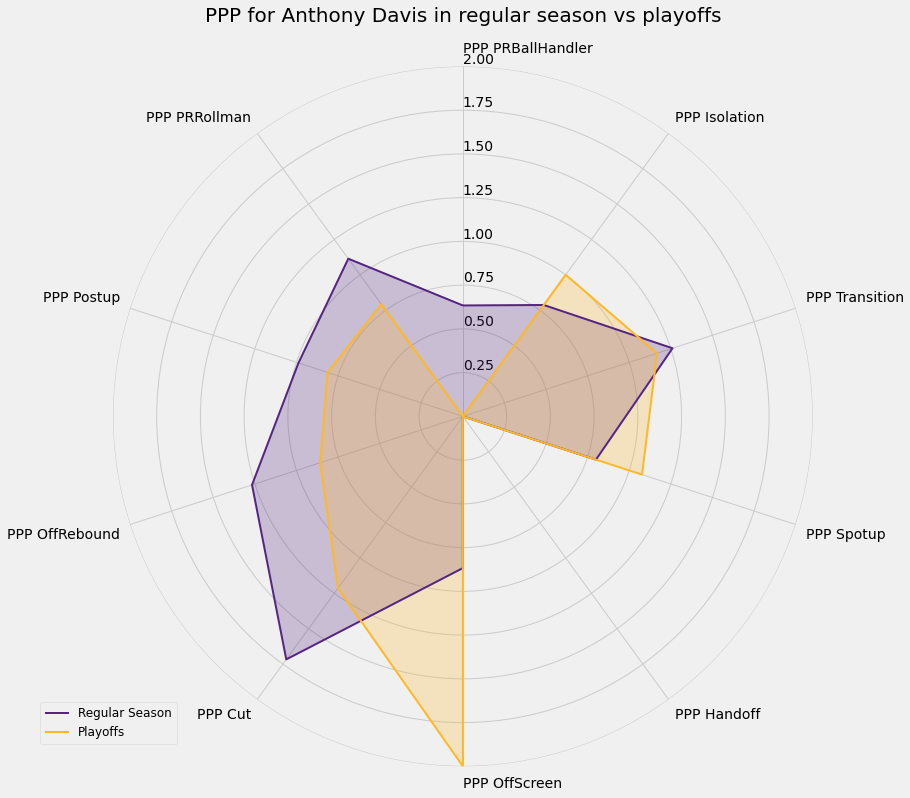

In [57]:
data_type = 'PPP'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Anthony Davis'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"PPP for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)

## LeBron

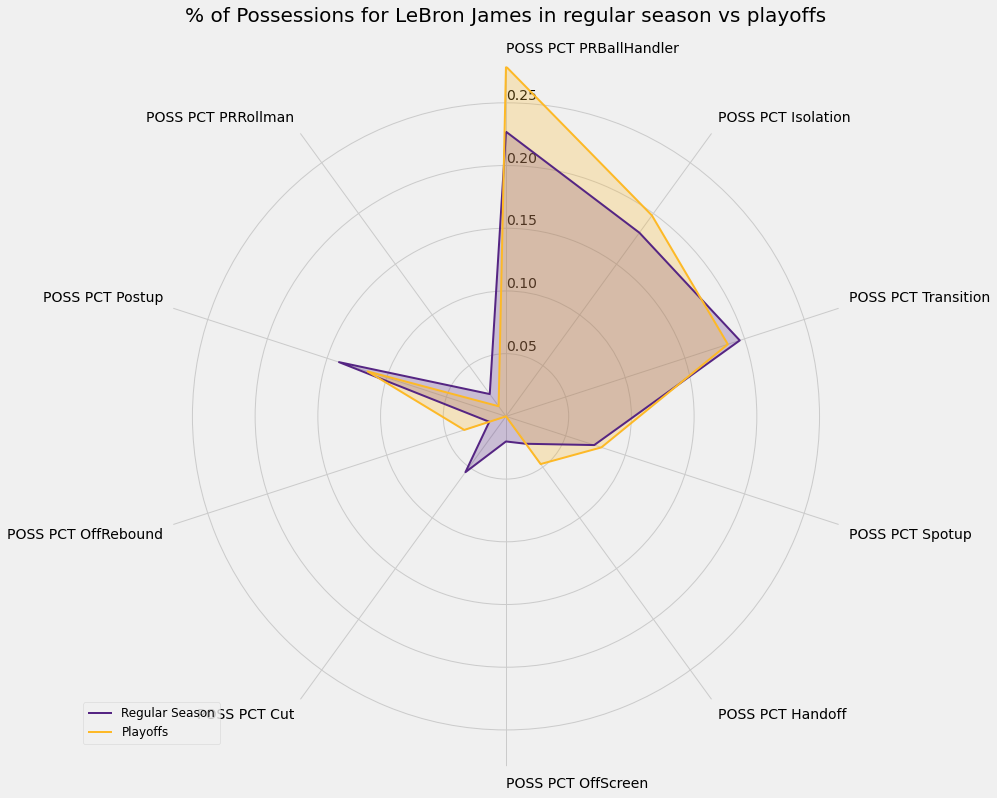

In [72]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'LeBron James'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"% of Possessions for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)

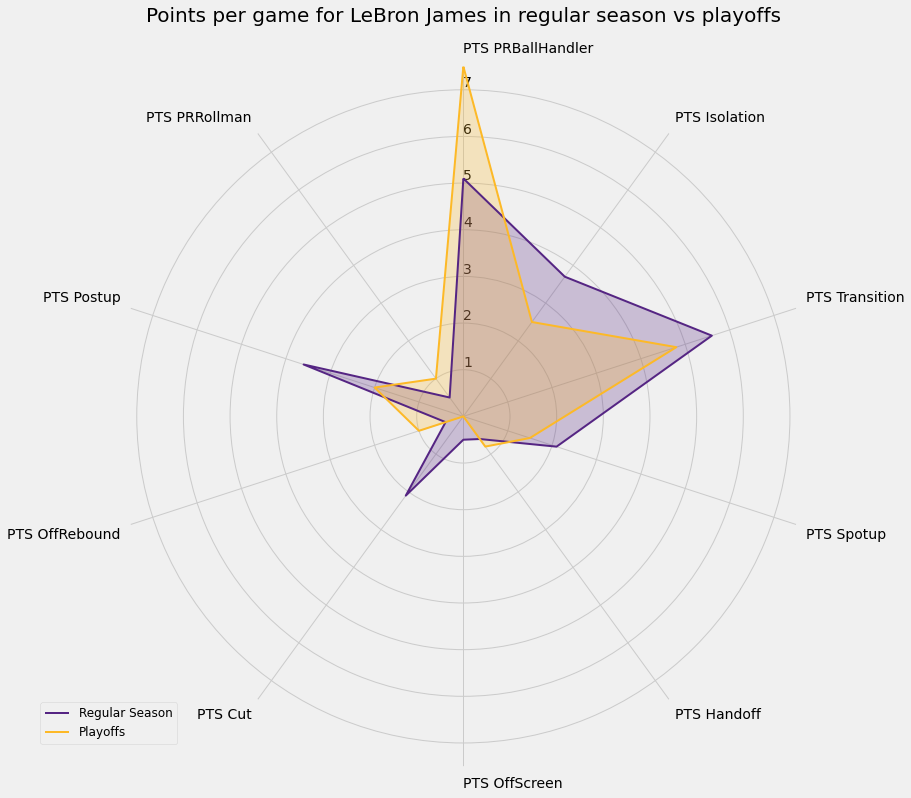

In [60]:
data_type = 'PTS'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'LeBron James'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"Points per game for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)

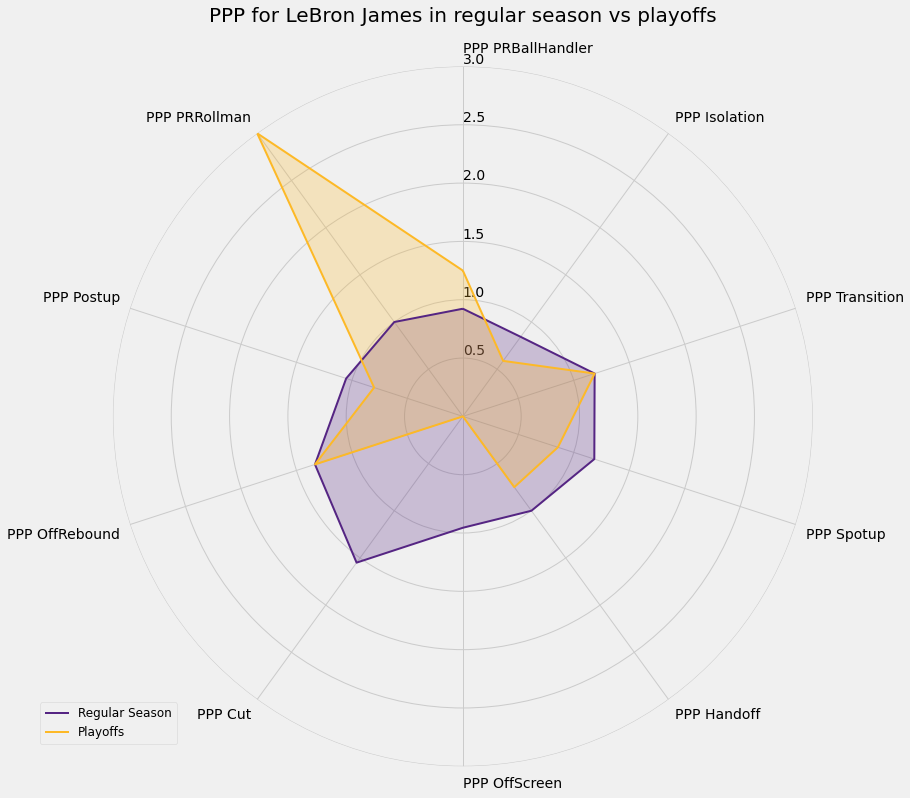

In [62]:
data_type = 'PPP'
pl_reg_df = get_interesting_data_player(cur_reg_player, data_type).fillna(0.0)
pl_po_df = get_interesting_data_player(cur_po_player, data_type).fillna(0.0)

#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'LeBron James'
#player_two = 'Damian Lillard'

first_df = pl_reg_df.loc[pl_reg_df.PLAYER_NAME == player_one]
second_df = pl_po_df.loc[pl_po_df.PLAYER_NAME == player_one]

plot_radar(
    title=f"PPP for {player_one} in regular season vs playoffs",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['Regular Season', 'Playoffs'],
    colors=[
        lakers_color,
        lakers_second
    ],
    alphas=[0.25, 0.25]
)

## Pull Up shooting

In [11]:
pull_up_regular = LeagueDashPtStats(season='2020-21', season_type_all_star='Regular Season', per_mode_simple='PerGame', player_or_team='Player', pt_measure_type='PullUpShot').get_data_frames()[0]

In [12]:
pull_up_po = LeagueDashPtStats(season='2020-21', season_type_all_star='Playoffs', per_mode_simple='PerGame', player_or_team='Player', pt_measure_type='PullUpShot').get_data_frames()[0]

In [13]:
merged_df = pd.merge(left=pull_up_regular, right=pull_up_po, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_REGULAR', '_PLAYOFFS'))

In [14]:
merged_df.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID_REGULAR',
       'TEAM_ABBREVIATION_REGULAR', 'GP_REGULAR', 'W_REGULAR', 'L_REGULAR',
       'MIN_REGULAR', 'PULL_UP_FGM_REGULAR', 'PULL_UP_FGA_REGULAR',
       'PULL_UP_FG_PCT_REGULAR', 'PULL_UP_PTS_REGULAR', 'PULL_UP_FG3M_REGULAR',
       'PULL_UP_FG3A_REGULAR', 'PULL_UP_FG3_PCT_REGULAR',
       'PULL_UP_EFG_PCT_REGULAR', 'TEAM_ID_PLAYOFFS',
       'TEAM_ABBREVIATION_PLAYOFFS', 'GP_PLAYOFFS', 'W_PLAYOFFS', 'L_PLAYOFFS',
       'MIN_PLAYOFFS', 'PULL_UP_FGM_PLAYOFFS', 'PULL_UP_FGA_PLAYOFFS',
       'PULL_UP_FG_PCT_PLAYOFFS', 'PULL_UP_PTS_PLAYOFFS',
       'PULL_UP_FG3M_PLAYOFFS', 'PULL_UP_FG3A_PLAYOFFS',
       'PULL_UP_FG3_PCT_PLAYOFFS', 'PULL_UP_EFG_PCT_PLAYOFFS'],
      dtype='object')

In [15]:
top_only = merged_df.sort_values(by='PULL_UP_FGA_PLAYOFFS', ascending=False).iloc[:30]

In [16]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.25
team_root_dir = '../../../team_logos_id/'
player_root_dir = '../player_imgs/'

def get_player_img(player_id, zoom=1.0):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom=0.1):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [17]:
top_only.loc[:, 'PULL_UP_EFG_PCT_REGULAR'] = top_only.PULL_UP_EFG_PCT_REGULAR * 100
top_only.loc[:, 'PULL_UP_EFG_PCT_PLAYOFFS'] = top_only.PULL_UP_EFG_PCT_PLAYOFFS * 100

Text(40, 8.0, "Note: the x-y value is in CENTER of player's image")

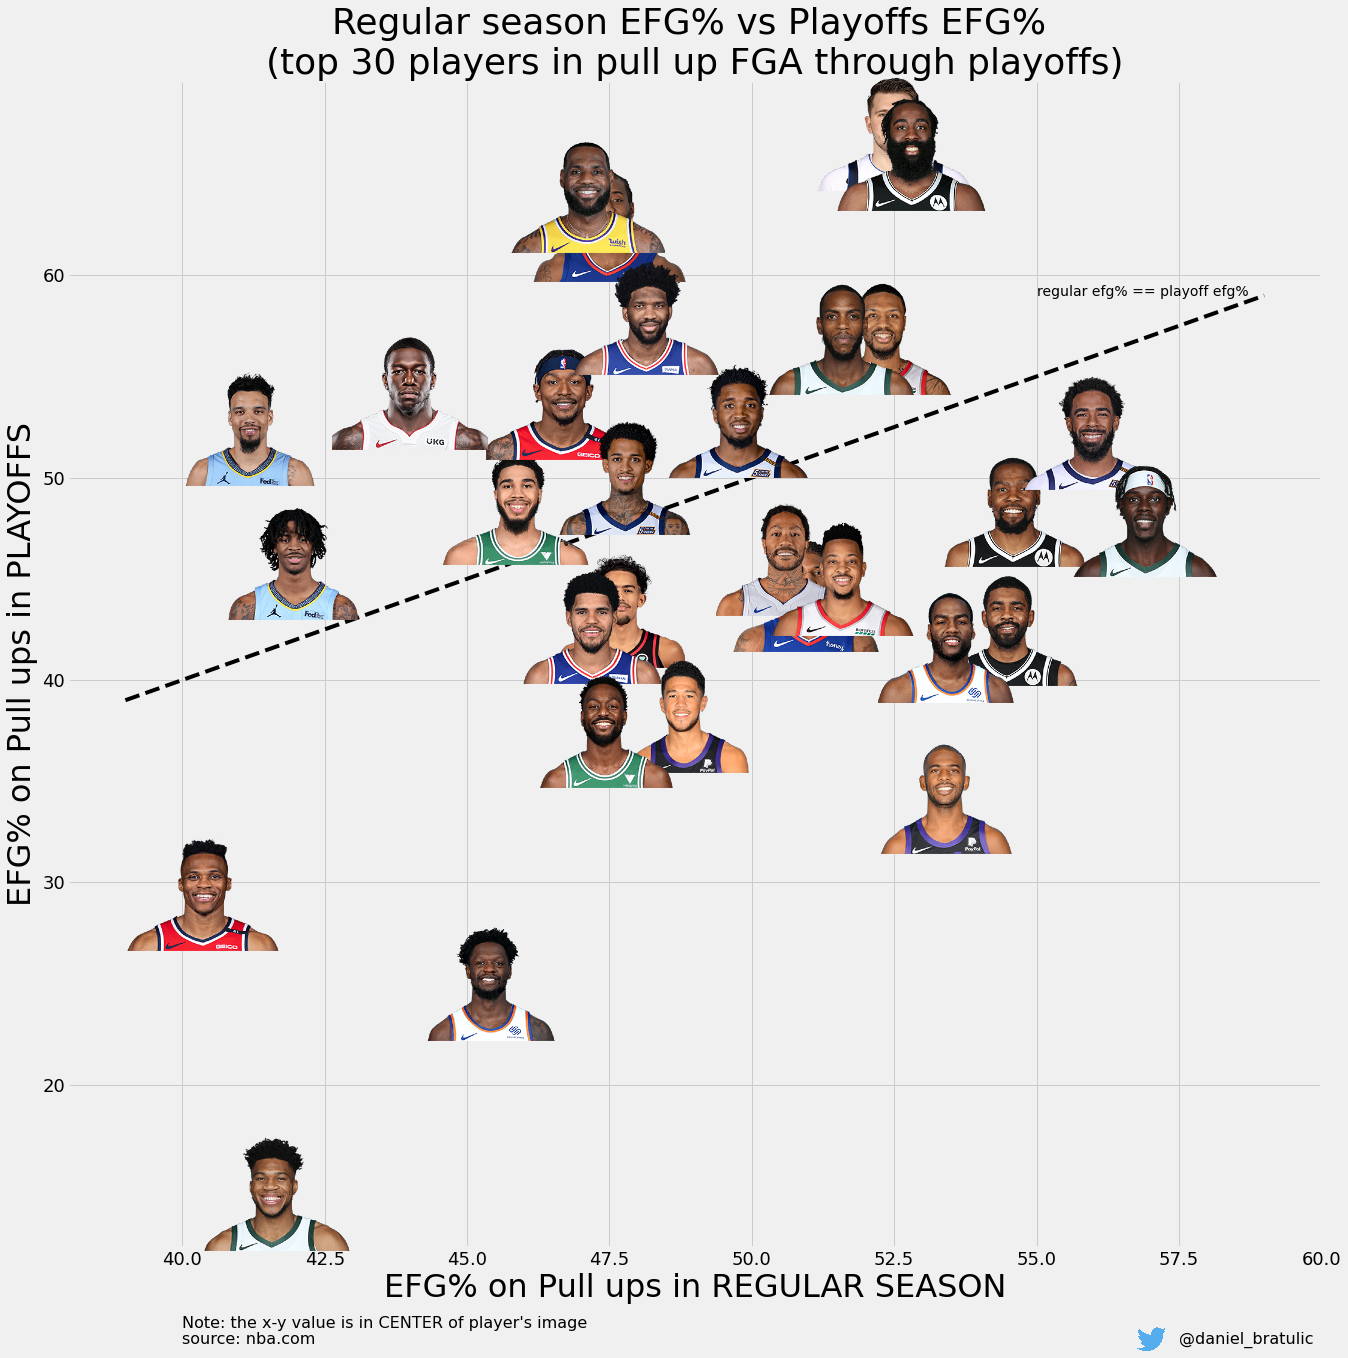

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=top_only.PULL_UP_EFG_PCT_REGULAR, y=top_only.PULL_UP_EFG_PCT_PLAYOFFS, s=10, alpha=0.5, edgecolors='black')
for index in range(len(top_only)):
    item = top_only.iloc[index]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID, zoom=0.6), (item.PULL_UP_EFG_PCT_REGULAR, item.PULL_UP_EFG_PCT_PLAYOFFS), frameon=False)
    ax.add_artist(ab)


#ax.plot(data, reg.predict(data.reshape(-1, 1)), color='black', ls='--', lw=2)
ax.tick_params(labelsize=18)
ax.set_xlabel("EFG% on Pull ups in REGULAR SEASON", size=32)
ax.set_ylabel("EFG% on Pull ups in PLAYOFFS", size=32)
ax.set_title("Regular season EFG% vs Playoffs EFG% \n(top 30 players in pull up FGA through playoffs)", size=36)


ax.plot(np.arange(39, 60, 1), np.arange(39, 60, 1), color='black', ls='--')
#ax.annotate("", xy=(55.5, 58.5), xytext=(51.5, 51.5), arrowprops=dict(arrowstyle="->", color='black', lw=2))
ax.text(x=55, y=59, s='regular efg% == playoff efg%')
"""rotation=30

ax.annotate("", xy=(51.5, 50.5), xytext=(51.5, 51.5), arrowprops=dict(arrowstyle="->", color='black', lw=2))
ax.text(x=50, y=51.5, s='Better in Clutch', rotation=rotation)
ax.text(x=50, y=48.5, s='Worse in Clutch', rotation=rotation)
"""
y_coord = 7.2
offset_image = OffsetImage(plt.imread(f'../../../twitter_logo.png'), zoom=0.025, )
offset_image.set_offset((1130, -3))
ax.add_artist(offset_image)
ax.text(x=57.5, y=y_coord, ha='left', s='@daniel_bratulic', size=16)
ax.text(x=40, y=y_coord, ha='left', s='source: nba.com', size=16)
ax.text(x=40, y=y_coord+0.8, ha='left', s="Note: the x-y value is in CENTER of player's image", size=16)




In [19]:
top_only.loc[:, 'EFG_PCT_DIFF'] = top_only.PULL_UP_EFG_PCT_PLAYOFFS-top_only.PULL_UP_EFG_PCT_REGULAR

In [20]:
top_only = top_only.sort_values(by='EFG_PCT_DIFF', ascending=False)

[Text(0.0, 0, ''),
 Text(0.1, 0, ''),
 Text(0.2, 0, ''),
 Text(0.30000000000000004, 0, ''),
 Text(0.4, 0, ''),
 Text(0.5, 0, ''),
 Text(0.6000000000000001, 0, ''),
 Text(0.7000000000000001, 0, ''),
 Text(0.8, 0, '')]

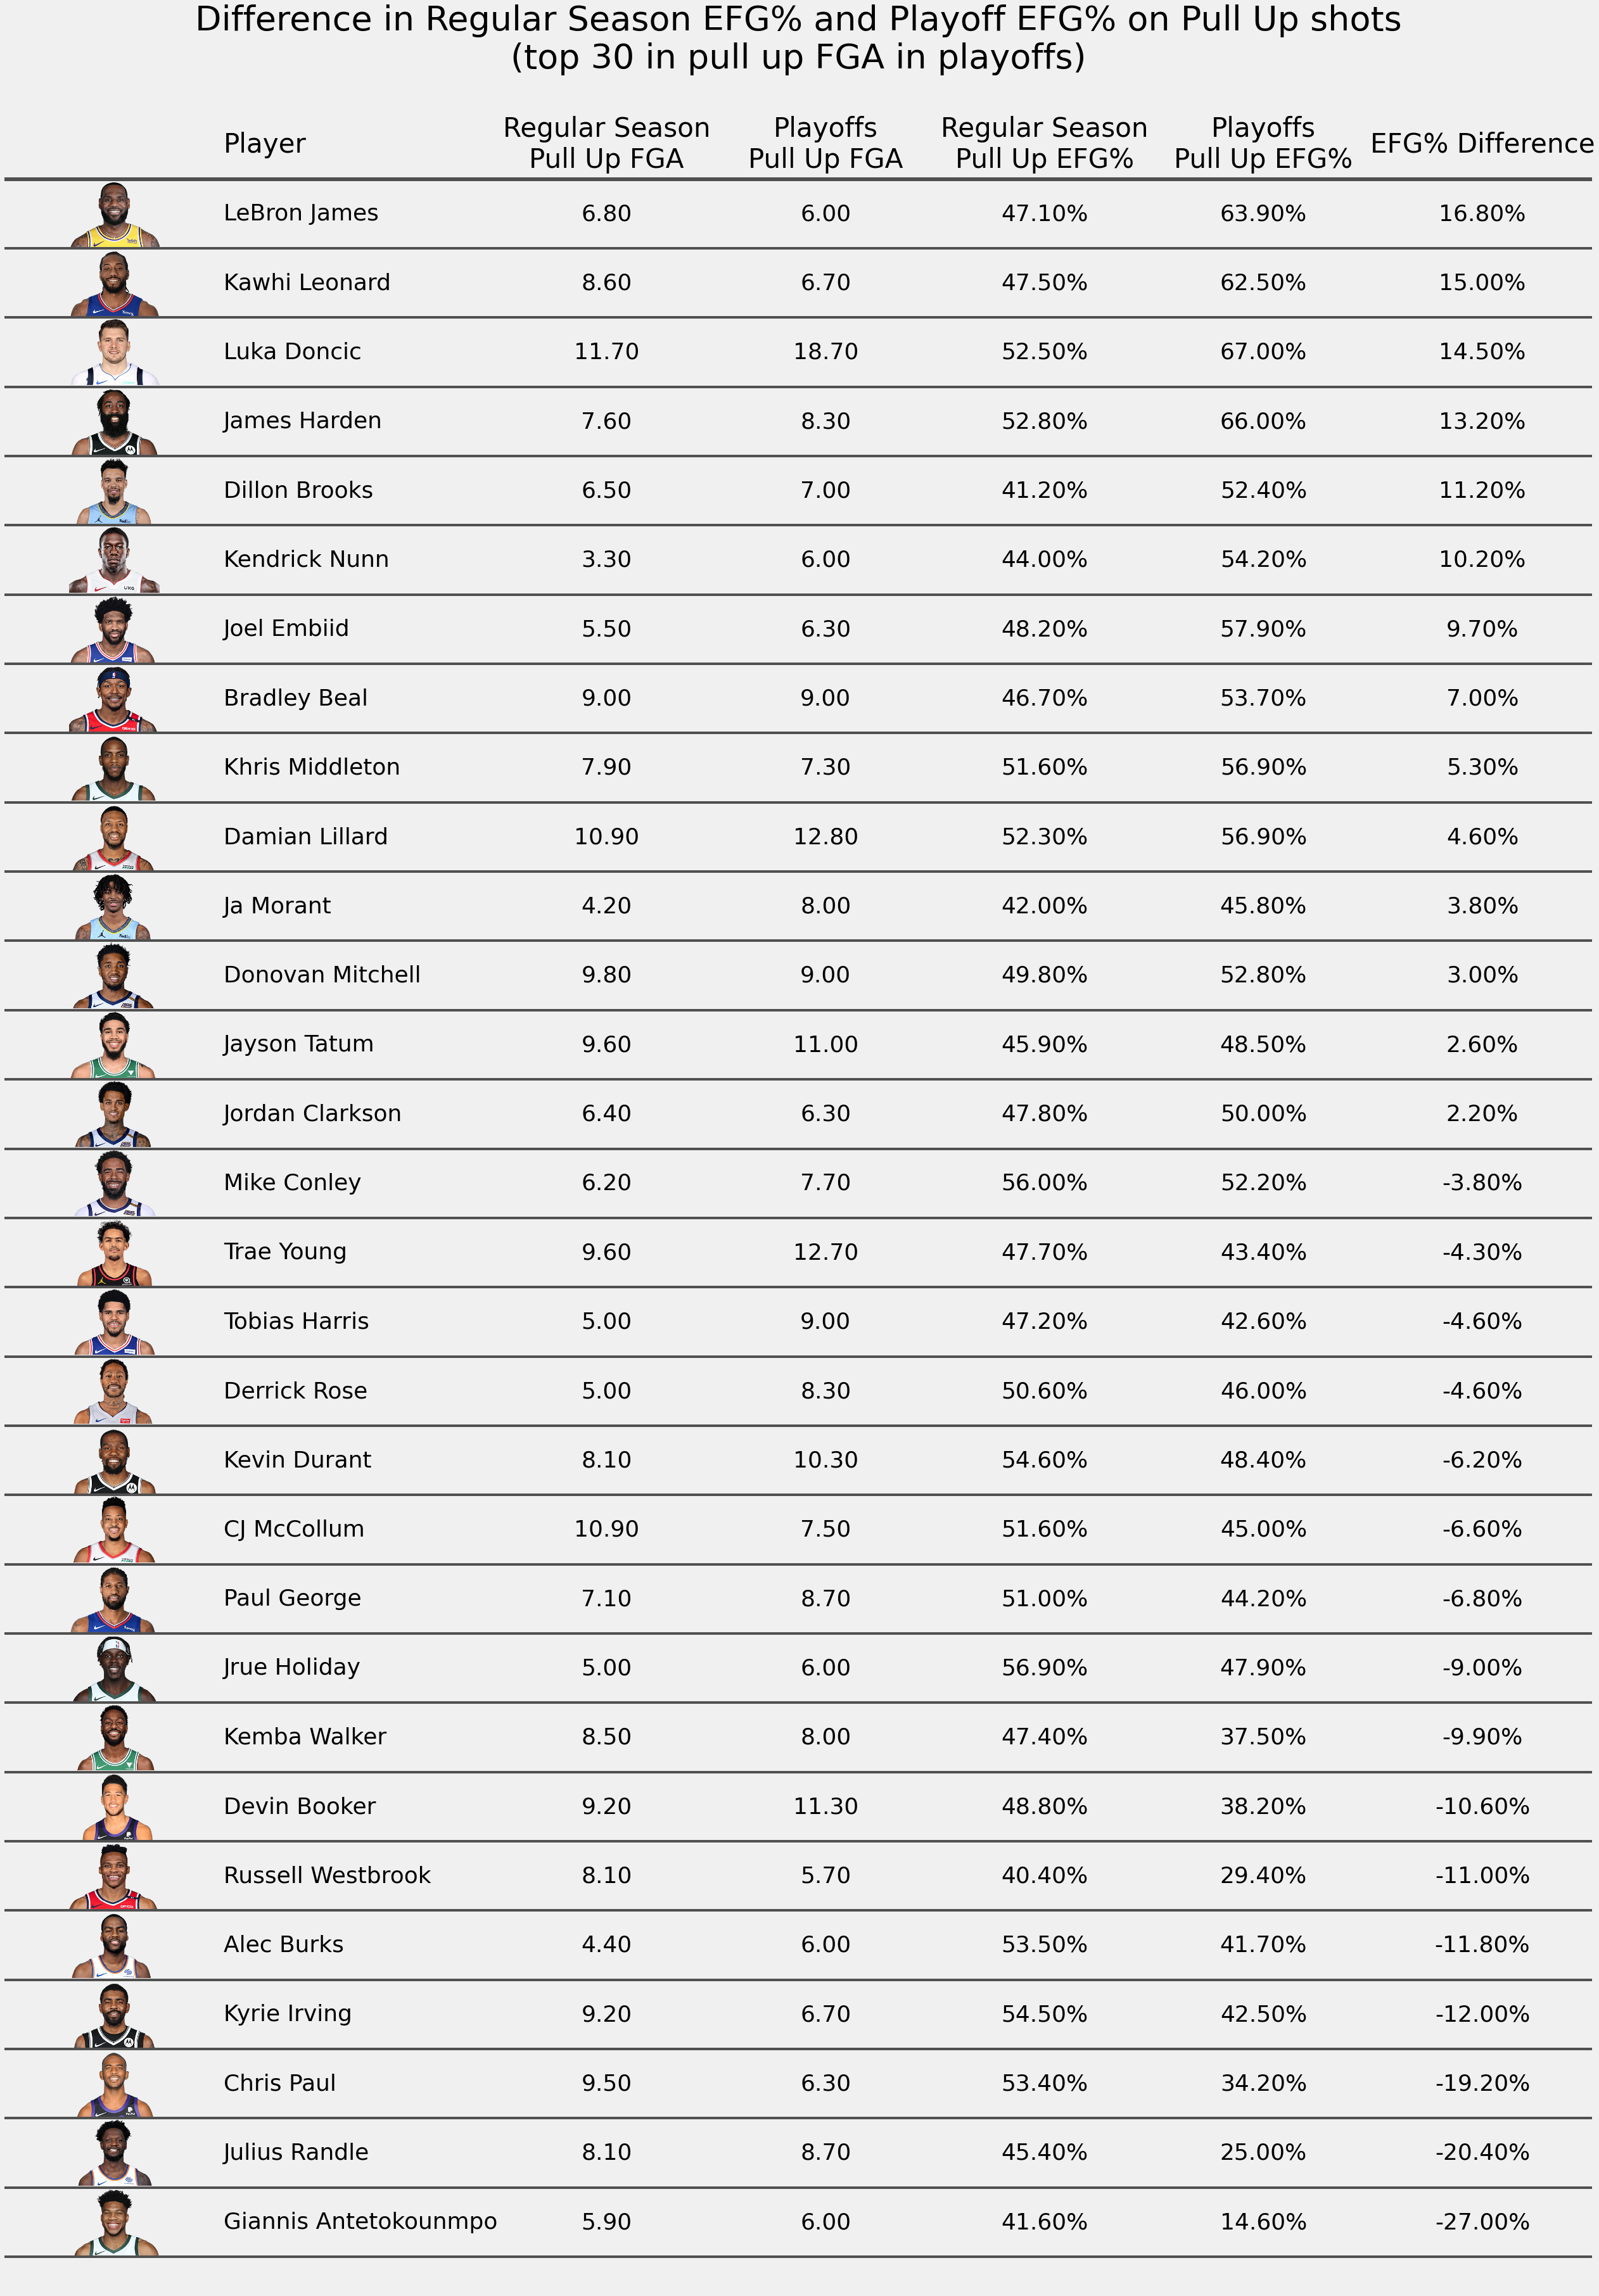

In [21]:
fig, ax = plt.subplots(figsize=(40, 60))
font_size = 36
font_title = 42
title_size = 54
top = len(top_only)
#top = 10

for i in range(top):
    item = top_only.iloc[i]
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = bball_cofee
    #    rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#1A1A1A', alpha=0.75, lw=4)
    
    ax.text(x=0.275, y=y_coord, ha='center', va='center', s=f"{item.PULL_UP_FGA_REGULAR:.2f}", size=font_size)
    ax.text(x=0.375, y=y_coord, ha='center', va='center', s=f"{item.PULL_UP_FGA_PLAYOFFS:.2f}", size=font_size)
    ax.text(x=0.475, y=y_coord, ha='center', va='center', s=f"{item.PULL_UP_EFG_PCT_REGULAR:.2f}%", size=font_size)
    ax.text(x=0.575, y=y_coord, ha='center', va='center', s=f"{item.PULL_UP_EFG_PCT_PLAYOFFS:.2f}%", size=font_size)
    ax.text(x=0.675, y=y_coord, ha='center', va='center', s=f"{item.PULL_UP_EFG_PCT_PLAYOFFS-item.PULL_UP_EFG_PCT_REGULAR:.2f}%", size=font_size)
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID, zoom=0.55), (0.05, y_coord), frameon=False)
    ax.add_artist(ab)
    
ax.text(x=0.1, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=0.275, y=top, s='Regular Season\nPull Up FGA', ha='center', va='center', size=font_title)
ax.text(x=0.375, y=top, s='Playoffs\nPull Up FGA', ha='center', va='center', size=font_title)
ax.text(x=0.475, y=top, s='Regular Season\nPull Up EFG%', ha='center', va='center', size=font_title)
ax.text(x=0.575, y=top, s='Playoffs\nPull Up EFG%', ha='center', va='center', size=font_title)
ax.text(x=0.675, y=top, s='EFG% Difference', ha='center', va='center', size=font_title)


ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, alpha=0.75, lw=6, color='#1A1A1A')
ax.set_title("Difference in Regular Season EFG% and Playoff EFG% on Pull Up shots\n(top 30 in pull up FGA in playoffs)", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=0, right=0.725)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [22]:
find_teams_by_full_name("Phoenix Suns")

[{'id': 1610612756,
  'full_name': 'Phoenix Suns',
  'abbreviation': 'PHX',
  'nickname': 'Suns',
  'city': 'Phoenix',
  'state': 'Arizona',
  'year_founded': 1968}]

In [23]:
suns_shots = ShotChartDetail(team_id=find_teams_by_full_name("Phoenix Suns")[0]['id'], player_id=0, context_measure_simple='FGA', season_type_all_star='Playoffs', season_nullable='2020-21').get_data_frames()[0]

In [27]:
suns_shots.SHOT_ZONE_BASIC.unique()

array(['Above the Break 3', 'Restricted Area', 'Right Corner 3',
       'Left Corner 3', 'In The Paint (Non-RA)', 'Mid-Range'],
      dtype=object)

In [29]:
corner_threes = suns_shots.loc[(suns_shots.SHOT_ZONE_BASIC == 'Right Corner 3') | (suns_shots.SHOT_ZONE_BASIC == 'Left Corner 3')]

In [30]:
corner_threes

GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID      PLAYER_NAME  \
3    Shot Chart Detail  0042000151             17    1626164     Devin Booker   
4    Shot Chart Detail  0042000151             24    1628969    Mikal Bridges   
7    Shot Chart Detail  0042000151             38    1628969    Mikal Bridges   
43   Shot Chart Detail  0042000151            292    1629661  Cameron Johnson   
44   Shot Chart Detail  0042000151            297    1629661  Cameron Johnson   
46   Shot Chart Detail  0042000151            307    1629661  Cameron Johnson   
87   Shot Chart Detail  0042000152             28    1628969    Mikal Bridges   
116  Shot Chart Detail  0042000152            332    1628969    Mikal Bridges   
130  Shot Chart Detail  0042000152            442    1626166    Cameron Payne   
133  Shot Chart Detail  0042000152            457     203109      Jae Crowder   
137  Shot Chart Detail  0042000152            479    1629661  Cameron Johnson   
138  Shot Chart Detail  0042000152            482    1629661  Cameron Johnson   
145  Shot Chart Detail  0042000152            544     203109      Jae Crowder   
164  Shot Chart Detail  0042000153             53    1628969    Mikal Bridges   
180  Shot Chart Detail  0042000153            152    1628470     Torrey Craig   
185  Shot Chart Detail  0042000153            193    1628470     Torrey Craig   
213  Shot Chart Detail  0042000153            406    1629661  Cameron Johnson   
215  Shot Chart Detail  0042000153            425    1628470     Torrey Craig   
217  Shot Chart Detail  0042000153            450    1628470     Torrey Craig   
230  Shot Chart Detail  0042000153            571    1626166    Cameron Payne   

        TEAM_ID     TEAM_NAME  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
3    1610612756  Phoenix Suns       1                 10                 16   
4    1610612756  Phoenix Suns       1                  9                 44   
7    1610612756  Phoenix Suns       1                  7                 59   
43   1610612756  Phoenix Suns       2                  2                 11   
44   1610612756  Phoenix Suns       2                  1                 36   
46   1610612756  Phoenix Suns       2                  0                 36   
87   1610612756  Phoenix Suns       1                 10                 48   
116  1610612756  Phoenix Suns       2                  1                 35   
130  1610612756  Phoenix Suns       3                  4                  8   
133  1610612756  Phoenix Suns       3                  2                 43   
137  1610612756  Phoenix Suns       3                  0                 30   
138  1610612756  Phoenix Suns       3                  0                  0   
145  1610612756  Phoenix Suns       4                  8                  9   
164  1610612756  Phoenix Suns       1                  7                  7   
180  1610612756  Phoenix Suns       2                 11                  7   
185  1610612756  Phoenix Suns       2                  8                  6   
213  1610612756  Phoenix Suns       3                  4                 25   
215  1610612756  Phoenix Suns       3                  3                 16   
217  1610612756  Phoenix Suns       3                  1                  8   
230  1610612756  Phoenix Suns       4                  5                 43   

     ... SHOT_ZONE_AREA SHOT_ZONE_RANGE SHOT_DISTANCE LOC_X LOC_Y  \
3    ...  Right Side(R)         24+ ft.            23   230   -13   
4    ...  Right Side(R)         24+ ft.            22   226   -24   
7    ...   Left Side(L)         24+ ft.            23  -234     6   
43   ...  Right Side(R)         24+ ft.            23   232    55   
44   ...  Right Side(R)         24+ ft.            23   234    38   
46   ...   Left Side(L)         24+ ft.            23  -234    37   
87   ...   Left Side(L)         24+ ft.            22  -229    12   
116  ...  Right Side(R)         24+ ft.            23   231     7   
130  ...  Right Side(R)       

In [32]:
from nba_api.stats.endpoints.videoevents import VideoEvents 

In [39]:
VideoEvents(game_id="0042000151", game_event_id="17").get_dict()

{'resource': 'videoevents',
 'parameters': {'GameID': '0042000151', 'GameEventID': 17},
 'resultSets': {'Meta': {'videoUrls': [{'uuid': '4549dfbf-fde2-4dcc-8065-afade5ada267',
     'dur': None,
     'stt': None,
     'stp': None,
     'sth': None,
     'stw': None,
     'mtt': None,
     'mtp': None,
     'mth': None,
     'mtw': None,
     'ltt': None,
     'ltp': None,
     'lth': None,
     'ltw': None}]},
  'playlist': [{'gi': '0042000151',
    'ei': 17,
    'y': 2021,
    'm': '05',
    'd': '23',
    'gc': '2021-05-23/LALPHX',
    'p': 1,
    'dsc': 'Booker 3PT Jump Shot (3 PTS) (Paul 1 AST)',
    'ha': 'PHX',
    'va': 'LAL',
    'hpb': 0,
    'hpa': 3,
    'vpb': 2,
    'vpa': 2,
    'pta': 0}]}}